VGG19 using max pooling
Using  cuda  to process


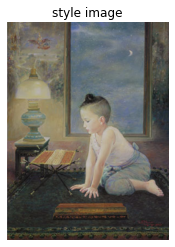

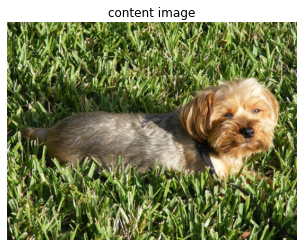

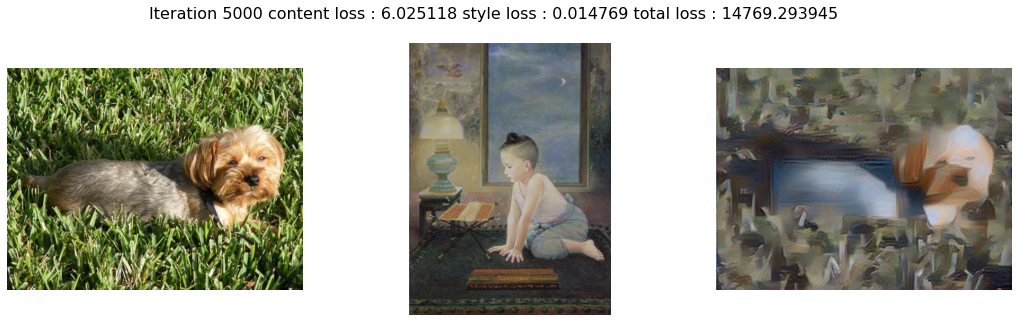

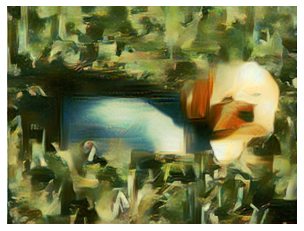

TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>

In [5]:
%run StyleTransfer_v1.py

<a href="https://colab.research.google.com/github/Pataraphorn/StyleTransfer/blob/main/StyleTransfer_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

In [ ]:
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="1234")

In [ ]:
init_git_cloudflared('https://github.com/Pataraphorn/StyleTransfer.git')

# Library

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, models

import os
import cv2 as cv
import pandas as pd

import requests
from io import BytesIO
import skimage.exposure as exposure

## functions

In [ ]:
def get_filter(model,model_weights,conv_layers):
    model_children = list(model.children())

    counter = 0
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter += 1
                        model_weights.append(child.weight)
                        conv_layers.append(child)
    print(f"Total convolutional layers: {counter}")

    for weight, conv in zip(model_weights, conv_layers):
        # print(f"WEIGHT: {weight} ====> SHAPE: {weight.shape}")
        print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

In [ ]:
def visualizeLayerFilter(convLayer,model_weights):
    plt.figure(figsize=(10, 8))
    for i, filter in enumerate(model_weights[convLayer]):
        plt.subplot(8, 8, i+1)
        plt.imshow(filter[0, :, :].cpu().detach(), cmap='gray')
        plt.axis('off')
        # plt.savefig('../outputs/filter.png')
    plt.show()

In [ ]:
def visualImageFilter(img,model_weights,conv_layers):
    # pass the image through all the layers
    results = [conv_layers[0](img)]
    for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))
    # make a copy of the `results`
    outputs = results
    # visualize 64 features from each layer 
    # (although there are more feature maps in the upper layers)
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(15, 13))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.cpu().data
        print('layer : ',num_layer,layer_viz.size())
        for i, filter in enumerate(layer_viz):
            if i == 64: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(8, 8, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        # print(f"Saving layer {num_layer} feature maps...")
        # plt.savefig(f"../outputs/layer_{num_layer}.png")
        plt.show()
        plt.close()

In [ ]:
#defining a method with three parameters i.e. image location, maximum size and shape   
def load_image(img_path=None,url=None,max_size=400,shape=None):  
# Open the image, convert it into RGB and store in a variable   
    if url is not None:
      response = requests.get(url)
      if response.status_code == 200:
          image = Image.open(BytesIO(response.content))
      else:
          print('An error has occurred.') 
    else:
      image=Image.open(img_path).convert('RGB')  
    # comparing image size with the maximum size   
    if max(image.size)>max_size:  
      size=max_size  
    else:  
      size=max(image.size)  
    # checking for the image shape  
    if shape is not None:  
       size=shape  
    #Applying appropriate transformation to our image such as Resize, ToTensor and Normalization  
    in_transform=transforms.Compose([  
        transforms.Resize(size),  
        transforms.ToTensor(),  
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])  
    #Calling in_transform with our image   
    image=in_transform(image).unsqueeze(0) #unsqueeze(0) is used to add extra layer of dimensionality to the image  
    #Returning image   
    return image  

def createData(path):
    image = []
    for filename in os.listdir(path):
        img = load_image(path+filename).to(device)
        image.append(img)
    return image

In [ ]:
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(Variable(img), size)).data

def resizeImage(image,size):
    img = []
    for i in range(len(image)):
        img.append(resize2d(image[i],size))
    return img

def im_convert(tensor):  
  image=tensor.cpu().clone().detach().numpy()     
  image=image.squeeze()  
  image=image.transpose(1,2,0)  
  image=image*np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5))  
  image=image.clip(0,1)  
  return image  

def im_convertT(img, max_size=None):
    # Rescale the image
    if (max_size==None):
        in_transform = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            # transforms.Lambda(lambda x: x.mul(255))
        ])    
    else:
        H, W, C = img.shape
        image_size = tuple([int((float(max_size) / max([H,W]))*x) for x in [H, W]])
        in_transform = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            # transforms.Lambda(lambda x: x.mul(255))
        ])
    # Convert image to tensor
    tensor = in_transform(img)
    tensor = tensor.unsqueeze(dim=0)
    return tensor
    
def showImage(image, row=3, col=8, title='Image'):
    fig, ax = plt.subplots(row,col,figsize=(14,5))
    fig.suptitle(title)
    for i in range(row):
        for j in range(col):
            ax[i,j].imshow(im_convert(image[j + i*10]),cmap='gray')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

In [ ]:
def showStyleContentTarget(style,content,target,title):
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(18,5))  
    fig.suptitle(title, fontsize=16)   
    #Plotting content image   
    ax1.imshow(im_convert(content))  
    ax1.axis('off')  
    #Plotting style image  
    ax2.imshow(im_convert(style))  
    ax2.axis('off')  
    #Plotting target image  
    ax3.imshow(im_convert(target))  
    ax3.axis('off') 
    plt.show() 

In [ ]:
def get_features(image,feature_layers,model):
    features = {}
    for name,layer in model._modules.items():
        image = layer(image)
        if name in feature_layers:
            features[feature_layers[name]]=image
    return  features

In [ ]:
#Initializing gram_matrix function for our tensor image   
def gram_matrix(tensor):  
   #Unwrapping the tensor dimensions into respective variables i.e. batch size, distance, height and width   
  _,d,h,w=tensor.size()   
  #Reshaping data into a two dimensional of array or two dimensional of tensor  
  tensor=tensor.view(d,h*w)  
  #Multiplying the original tensor with its own transpose using torch.mm   
  #tensor.t() will return the transpose of original tensor  
  gram=torch.mm(tensor,tensor.t())  
  #Returning gram matrix   
  return gram  

# Initialization of VGG-19 model
https://www.javatpoint.com/style-transferring-in-pytorch

## Model vgg

In [ ]:
#importing model features   
vgg=models.vgg19(pretrained=True).features  #we are using pre-trained model   
# Maintain parameter constant setting  ## freeze the layers
for param in vgg.parameters():  
    param.requires_grad_(False)  

In [ ]:
# def get_device():
#     if torch.cuda.is_available():
#         device = 'cuda'
#     else:
#         device = 'cpu'
#     print(device)
#     return device
# device = get_device()

In [ ]:
#Implementing device   
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)
#Attaching our vgg model to our device
vgg.to(device)   

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
model_weights = []
conv_layers = []
get_filter(vgg,model_weights,conv_layers)

Total convolutional layers: 16
CONV: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 3, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 128, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

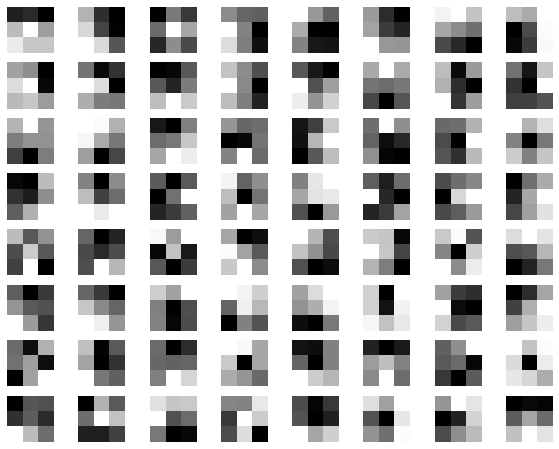

In [ ]:
visualizeLayerFilter(0,model_weights)

## Model AvgVgg19 : Change to average pooling

In [ ]:
AvgVgg19 = models.vgg19(pretrained=True).features  #we are using pre-trained model   
# Maintain parameter constant setting  ## freeze the layers
for param in AvgVgg19.parameters():  
    param.requires_grad_(False)  

In [ ]:
layers = {'4':'max_1',
            '9':'max_2',
            '18':'max_3',
            '27':'max_4',
            '36':'max_5'}
for name, layer in AvgVgg19._modules.items():
    if name in layers: 
        AvgVgg19._modules[name] = nn.AvgPool2d(kernel_size=2, stride=2,padding=0)

In [ ]:
#Implementing device   
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)
#Attaching our vgg model to our device
AvgVgg19.to(device)   

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [ ]:
modelAvg_weights = []
convAvg_layers = []
get_filter(AvgVgg19,modelAvg_weights,convAvg_layers)

Total convolutional layers: 16
CONV: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 3, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 128, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

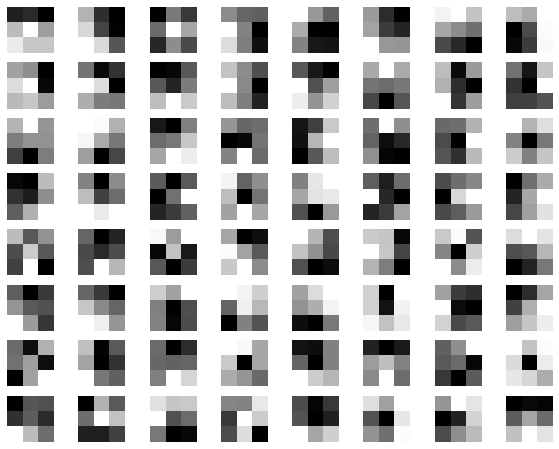

In [ ]:
visualizeLayerFilter(0,modelAvg_weights)

# Preprocess image
https://www.javatpoint.com/image-loading-and-transformation-for-style-transferring-in-pytorch

### Style image

#### Load style image

In [ ]:
# #load style image data
# ChakrabhandStyle = createData('/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/จักรพันธุ์_โปษยกฤต/')
# ChaloodStyle = createData('/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/ชลูด_นิ่มเสมอ/')

# #save original style image
# torch.save(ChakrabhandStyle, './DataPytorch/Style/imgOriginal_ChakrabhandStyle.pt')
# torch.save(ChaloodStyle, './DataPytorch/Style/imgOriginal_ChaloodStyle.pt')

# # resize style image to size 224*224
# img_ChakrabhandStyle = resizeImage(ChakrabhandStyle, (224,224))
# img_ChaloodStyle = resizeImage(ChaloodStyle, (224,224))

# #save style image size 224*224
# torch.save(img_ChakrabhandStyle, './DataPytorch/Style/img224x224_ChakrabhandStyle.pt')
# torch.save(img_ChaloodStyle, './DataPytorch/Style/img224x224_ChaloodStyle.pt')

Original style image

In [ ]:
# #load original style image
# ChakrabhandStyle = torch.load('./DataPytorch/Style/imgOriginal_ChakrabhandStyle.pt')
# ChaloodStyle = torch.load('./DataPytorch/Style/imgOriginal_ChaloodStyle.pt')

# print('Number of Chakrabhand Style : ',len(ChakrabhandStyle))
# print('Number of Chalood Style : ',len(ChaloodStyle))

# #show original style image
# showImage(ChakrabhandStyle, title='Chakrabhand Style')
# showImage(ChaloodStyle, title='Chakrabhand Style')

#### info style image

In [ ]:
# #load style image size 224*224
# img_ChakrabhandStyle = torch.load('./DataPytorch/Style/img224x224_ChakrabhandStyle.pt')
# img_ChaloodStyle = torch.load('./DataPytorch/Style/img224x224_ChaloodStyle.pt')

# #show style image size 224*224
# print('Number of Chakrabhand Style : ',len(img_ChakrabhandStyle), '\n  Shape : ',img_ChakrabhandStyle[0].shape)
# print('Number of Chalood Style : ',len(img_ChaloodStyle), '\n  Shape : ',img_ChaloodStyle[0].shape)

# showImage(img_ChakrabhandStyle, title='Chakrabhand Style')
# showImage(img_ChaloodStyle, title='Chalood Style')

### Content image

#### Load content image

In [ ]:
# # Load Content Human Image
# !wget -c https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
# !tar -xvf imdb_crop.tar

# # Load Content Animal Image
# !wget -c https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !tar -zxvf images.tar.gz
# os.rename('./images', './animals')

# #animals data have .mat
# os.remove('./animals/Abyssinian_100.mat')
# os.remove('./animals/Abyssinian_101.mat')
# os.remove('./animals/Abyssinian_102.mat')

In [ ]:
# #Load Content data 

# # HumanContent = createHumanData('/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/imdb_crop/')
# # HumanContent has many data so use 763 images

# HumanContent = createData('/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/imdb_crop/00/')

# HumanContent = []
# for i in range(92):
#     path = '/content/imdb_crop/%02d' % (i)
#     for j in range(8):
#         filenames = os.listdir(path)
#         img = load_image(path+'/'+filenames[j]).to(device)
#         HumanContent.append(img)

# AnimalContent = createData('/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/animals/')
# # AnimalContent has many data so use 736 images

# AnimalContent = []
# for filename in os.listdir('/content/images/'):
#     num = filename.split('.')[0]
#     num = num.split('_')[-1]
#     if(int(num) % 10 == 0):
#         img = load_image('/content/images/'+filename).to(device)
#         AnimalContent.append(img)

# #save original content image
# torch.save(HumanContent, '/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/DataPytorch/Content/imgOriginal_HumanContent.pt')
# torch.save(AnimalContent, '/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/DataPytorch/Content/imgOriginal_AnimalContent.pt')

# #load original style image
# HumanContent = torch.load('./DataPytorch/Content/imgOriginal_HumanContent.pt')
# AnimalContent = torch.load('./DataPytorch/Content/imgOriginal_AnimalContent.pt')

# #resize style image to size 224*224
# img_HumanContent = resizeImage(HumanContent, (512,512))
# img_AnimalContent = resizeImage(AnimalContent, (512,512))

# #save style image size 224*224
# torch.save(img_HumanContent, '/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/DataPytorch/Content/img512x512_HumanContent.pt')
# torch.save(img_AnimalContent, '/content/drive/MyDrive/Colab Notebooks/Senior Project/Project/DataPytorch/Content/img512x512_AnimalContent.pt')

#### info content image

In [ ]:
# #load style image size 224*224
# img_HumanContent = torch.load('./DataPytorch/Content/img224x224_HumanContent.pt')
# img_AnimalContent = torch.load('./DataPytorch/Content/img224x224_AnimalContent.pt')

# #show style image size 224*224
# print('Number of Human Content : ',len(img_HumanContent), '\n  Shape : ',img_HumanContent[0].shape)
# print('Number of Animal Content : ',len(img_AnimalContent), '\n  Shape : ',img_AnimalContent[0].shape)

# showImage(img_HumanContent, title='Human Content')
# showImage(img_AnimalContent, title='Animal Content')

In [ ]:
# content = img_HumanContent + img_AnimalContent
# print('Number of Content : ',len(content))
# showImage(content[725:], title='Content Image')

# Import Image

In [ ]:
def showAImg(img,name='Image'):
    plt.title(name)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# STYLE_IMG_PATH = r'StyleImage\Chakrabhan\0001.jpg'
# CONTENT_IMG_PATH = r'Test\ContentImg.jpg'

# style_image = load_image(STYLE_IMG_PATH).to(device)
# showAImg(im_convert(style_image),'style image')
# content_image = load_image(CONTENT_IMG_PATH).to(device)
# showAImg(im_convert(content_image), 'content image')

# # style_image = im_convertT(style_image)
# # content_image = im_convertT(style_image)

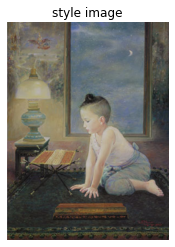

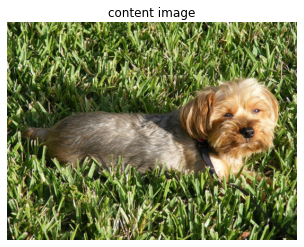

In [ ]:
STYLE_IMG_URL = 'https://github.com/nawaritlk/Senior_project/blob/frong/Model/StyleImage/Chakrabhan/0001.jpg?raw=true'
CONTENT_IMG_URL = 'https://github.com/nawaritlk/Senior_project/blob/frong/Model/Test/ContentImg.jpg?raw=true'

style_image = load_image(url=STYLE_IMG_URL).to(device)
showAImg(im_convert(style_image),'style image')
content_image = load_image(url=CONTENT_IMG_URL).to(device)
showAImg(im_convert(content_image), 'content image')

# Generate image

In [ ]:
def train(content_image,content_weight,style_image,style_weight,model,steps):
    feature_layers = {'0':'conv1_1','5':'conv2_1','10':'conv3_1','19':'conv4_1','21':'conv4_2','28':'conv5_1'}
    content_features=get_features(content_image,feature_layers,model)
    style_features=get_features(style_image,feature_layers,model)

    style_grams={layer:gram_matrix(style_features[layer]) for layer in style_features}  

    #Initializing style_weights dictionary  
    style_weights={'conv1_1':1.,      #Key 1 with max value 1  
                'conv2_1':0.75,  #Key 2 with max value 0.75  
                'conv3_1':0.2,    #Key 3 with max value 0.2  
                'conv4_1':0.2,   #Key 4 with max value 0.2  
                'conv5_1':0.2}   #Key 5 with max value 0.2  

    # show_every=15000
    show_every = steps

    target=content_image.clone().requires_grad_(True).to(device)
    # target=torch.randn(content_image.size()).type_as(content_image.data).requires_grad_(True).to(device) #random init

    optimizer=optim.Adam([target],lr=0.003)  
    result = []

    for ii in range(1,steps+1):
        target_features = get_features(target,feature_layers,model)
        content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)  
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            _, d, h, w = target_feature.shape
            style_loss += layer_style_loss / (d * h * w)
        total_loss = content_weight*content_loss+style_weight*style_loss

        #Using the optimizer to update parameters within our target image
        optimizer.zero_grad()  
        total_loss.backward()  
        optimizer.step()  

        #Comparing the iteration variable with our show every    
        if ii % show_every==0:
            result.append([ii,style_loss.item(),content_loss.item(),total_loss.item(),target])
            # print('Iteration ',ii,' / content loss = ',content_loss.item(),'  style loss = ',style_loss.item(),' => total loss = ',total_loss.item())
            # plt.imshow(im_convert(target))  
            # plt.axis('off')  
            # plt.show()
        #print('Iteration ',ii,' / content loss = ',content_loss.item(),'  style loss = ',style_loss.item(),' => total loss = ',total_loss.item())
    return target,result

# Result

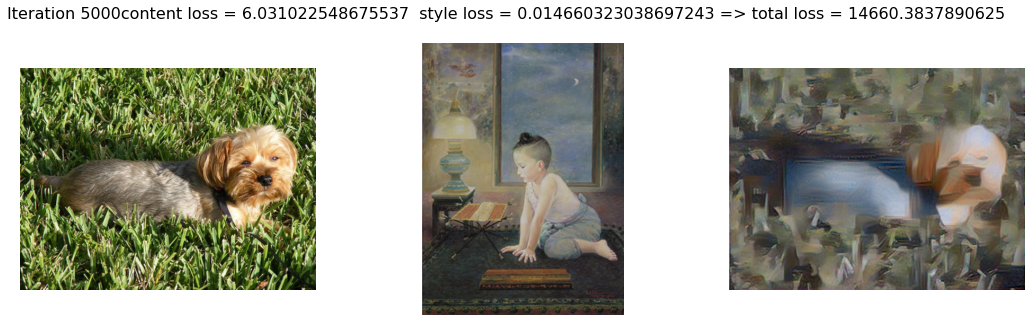

In [ ]:
iteration = 5000
target,result = train(content_image,1e-2,style_image,1e6,vgg,iteration)
title = 'Iteration '+str(result[0][0])+'content loss = '+str(result[0][2])+'  style loss = '+str(result[0][1])+' => total loss = '+str(result[0][3])
showStyleContentTarget(style_image, content_image,target,title)

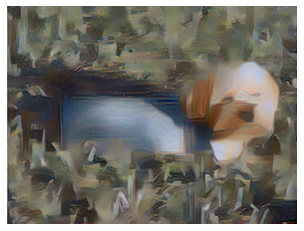

In [ ]:
plt.imshow(im_convert(target))
plt.axis('off')
plt.show()

In [ ]:
from torchvision.utils import save_image
save_image(target[0], 'result_test1.jpg')

## Histogram matching

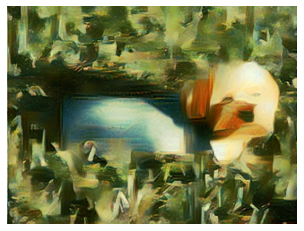

In [ ]:
multi = True if tgt.shape[-1] > 1 else False
preserve_img = exposure.match_histograms(tgt, cnt, multichannel = multi)
plt.imshow(preserve_img)
plt.axis('off')
plt.show()